# Segmentation

In [1]:
import numpy as np
import tensorflow as tf

from utils.data import load_images_and_segments
from utils.data import get_training_dataset, get_validation_dataset, get_test_dataset
from utils.plotting import list_show_annotation, show_annotation_and_prediction
from utils.metrics import class_wise_metrics

In [2]:
IMAGE_ORDERING = 'channels_last'
BATCH_SIZE = 32
N_CLASSES = 11
COLORS = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(N_CLASSES)]

## Load data

In [3]:
# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments("data")

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

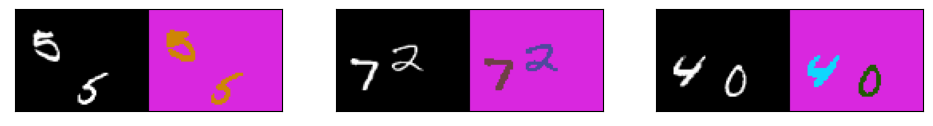

In [4]:
list_show_annotation(training_dataset, 3, COLORS)

## Create model

In [5]:
def conv_block(input_tensor, filters, kernel_size):
    '''
    Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    kernel_size (int) -- kernel_size setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers

    Returns:
    (tensor) max pooled and batch-normalized features of the input 
    '''
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(input_tensor)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(x)
    x = tf.keras.layers.ReLU()(x)
    return x


def encoder_block(input_tensor, filters, kernel_size, pooling_size, pool_strides):
    '''
    Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    kernel_size (int) -- kernel_size setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers

    Returns:
    (tensor) max pooled and batch-normalized features of the input 
    '''
    out = conv_block(input_tensor, filters, kernel_size)
    x = tf.keras.layers.MaxPooling2D(pooling_size, strides=pool_strides)(out)
    return x, out

In [6]:
def unet_encoder(input_height=64, input_width=84):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))

    # pad the input image width to 96 pixels
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input)
    
    # Block 1
    x, e1 = encoder_block(x, filters=64, kernel_size=3, pooling_size=2, pool_strides=2)
    
    # Block 2
    x, e2 = encoder_block(x, filters=128, kernel_size=3, pooling_size=2, pool_strides=2)

    # Block 3
    x, e3 = encoder_block(x, filters=256, kernel_size=3, pooling_size=2, pool_strides=2)
    
    # Block 4
    x, e4 = encoder_block(x, filters=512, kernel_size=3, pooling_size=2, pool_strides=2)

    return (e1, e2, e3, e4), img_input, x

In [7]:
def bottle_neck(x, filters=1024):
    x = conv_block(x, filters=filters, kernel_size=3)
    return x

In [8]:
def unet_decoder(bn_out, convs, n_classes):
    # features from the encoder stage
    e1, e2, e3, e4 = convs
    
    d = tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, data_format=IMAGE_ORDERING)(bn_out)
    d = tf.keras.layers.Cropping2D(cropping=(1,1))(d)
    
    d = tf.keras.layers.Add()([d, e4])
    d = conv_block(d, 512, kernel_size=2)
    

    d = tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, data_format=IMAGE_ORDERING)(d)
    d = tf.keras.layers.Cropping2D(cropping=(1,1))(d)
    d = tf.keras.layers.Add()([d, e3])
    d = conv_block(d, 256, kernel_size=2)
    
    d = tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, data_format=IMAGE_ORDERING)(d)
    d = tf.keras.layers.Cropping2D(cropping=(1,1))(d)
    d = tf.keras.layers.Add()([d, e2])
    d = conv_block(d, 128, kernel_size=2)

    d = tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, data_format=IMAGE_ORDERING)(d)
    d = tf.keras.layers.Cropping2D(cropping=(1,1))(d)
    d = tf.keras.layers.Add()([d, e1])
    d = conv_block(d, 64, kernel_size=2)
    
    d = tf.keras.layers.Conv2D(n_classes, kernel_size=1, strides=1, data_format=IMAGE_ORDERING)(d)
    d = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(d)

    # append a sigmoid activation
    d = (tf.keras.layers.Activation('sigmoid'))(d)

    return d

In [9]:
def unet(n_classes=N_CLASSES):
    convs, img_input, enc_out = unet_encoder()
    bn_out = bottle_neck(enc_out, 1024)
    dec_out = unet_decoder(bn_out, convs, n_classes)
    
    model = tf.keras.Model(inputs=img_input, outputs=dec_out)
    model.summary()
    return model

In [10]:
# define model
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 96, 64)   640         ['zero_padding2d[0][0]']         
                                                                                                  
 re_lu (ReLU)                   (None, 64, 96, 64)   0           ['conv2d[0][0]']                 
                                                                                              

 conv2d_13 (Conv2D)             (None, 16, 24, 256)  262400      ['re_lu_12[0][0]']               
                                                                                                  
 re_lu_13 (ReLU)                (None, 16, 24, 256)  0           ['conv2d_13[0][0]']              
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 34, 50, 128)  524416     ['re_lu_13[0][0]']               
 spose)                                                                                           
                                                                                                  
 cropping2d_2 (Cropping2D)      (None, 32, 48, 128)  0           ['conv2d_transpose_2[0][0]']     
                                                                                                  
 add_2 (Add)                    (None, 32, 48, 128)  0           ['cropping2d_2[0][0]',           
          

                                                                                                  
 re_lu_6 (ReLU)                 (None, 8, 12, 512)   0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 8, 12, 512)   2359808     ['re_lu_6[0][0]']                
                                                                                                  
 re_lu_7 (ReLU)                 (None, 8, 12, 512)   0           ['conv2d_7[0][0]']               
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 4, 6, 512)   0           ['re_lu_7[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 4, 6, 1024)   4719616     ['max_pooling2d_3[0][0]']        
          

 cropping2d_4 (Cropping2D)      (None, 64, 84, 11)   0           ['conv2d_18[0][0]']              
                                                                                                  
 activation (Activation)        (None, 64, 84, 11)   0           ['cropping2d_4[0][0]']           
                                                                                                  
Total params: 32,772,043
Trainable params: 32,772,043
Non-trainable params: 0
__________________________________________________________________________________________________


In [112]:
# compile model

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Train model

In [14]:
steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE

In [113]:
EPOCHS = 5
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, 
                    validation_data=validation_dataset, validation_steps=validation_steps, 
                    epochs=EPOCHS)

Epoch 1/5
125/125 [==============================] - 123s 917ms/step - loss: 0.5441 - accuracy: 0.9351 - val_loss: 0.1426 - val_accuracy: 0.9484
Epoch 2/5
125/125 [==============================] - 113s 907ms/step - loss: 0.1257 - accuracy: 0.9543 - val_loss: 0.1219 - val_accuracy: 0.9568
Epoch 3/5
125/125 [==============================] - 112s 900ms/step - loss: 0.0761 - accuracy: 0.9716 - val_loss: 0.0443 - val_accuracy: 0.9852
Epoch 4/5
125/125 [==============================] - 113s 907ms/step - loss: 0.0355 - accuracy: 0.9881 - val_loss: 0.0276 - val_accuracy: 0.9910
Epoch 5/5
125/125 [==============================] - 112s 897ms/step - loss: 0.0224 - accuracy: 0.9924 - val_loss: 0.0220 - val_accuracy: 0.9927


In [ ]:
# save model
model.save("models/unet_model.h5")

In [12]:
# load model
model.load_weights("./models/unet_model.h5")

In [15]:
results = model.predict(test_dataset, steps=test_steps)
results = np.argmax(results, axis=3)

print(results.shape)

6/6 [==============================] - 20s 103ms/step
(192, 64, 84)


### Visualize Predictions

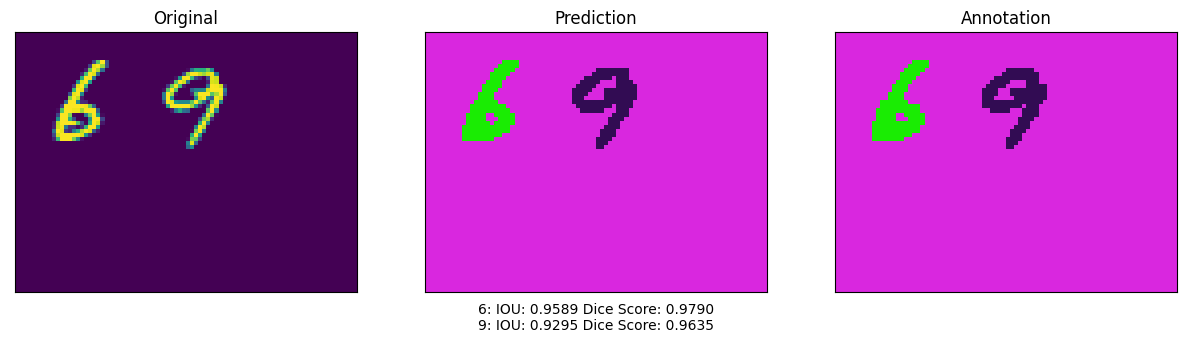

In [28]:
idx = 71

ds = test_dataset.unbatch()
ds = ds.batch(192)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
    y_true_segments = annotation
    images = image
  
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[idx], axis=2), results[idx])  
show_annotation_and_prediction(image[idx], annotation[idx], results[idx], iou, dice_score, COLORS)
plt.savefig("sample_prediction.jpg", bbox_inches="tight")

In [25]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
    print(f"Digit {idx}: IOU: {iou:.4f} Dice Score: {dice_score:.4f}")
    average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
    print("You passed!")
else:
    print("You failed. Please check your model and re-train")

Digit 0: IOU: 0.9051 Dice Score: 0.9502
Digit 1: IOU: 0.8449 Dice Score: 0.9159
Digit 2: IOU: 0.7910 Dice Score: 0.8833
Digit 3: IOU: 0.7450 Dice Score: 0.8539
Digit 4: IOU: 0.8776 Dice Score: 0.9348
Digit 5: IOU: 0.8156 Dice Score: 0.8985
Digit 6: IOU: 0.9039 Dice Score: 0.9495
Digit 7: IOU: 0.8820 Dice Score: 0.9373
Digit 8: IOU: 0.8612 Dice Score: 0.9254
Digit 9: IOU: 0.7699 Dice Score: 0.8700

Grade is 83.96205838143143
You passed!
